In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image

%matplotlib inline

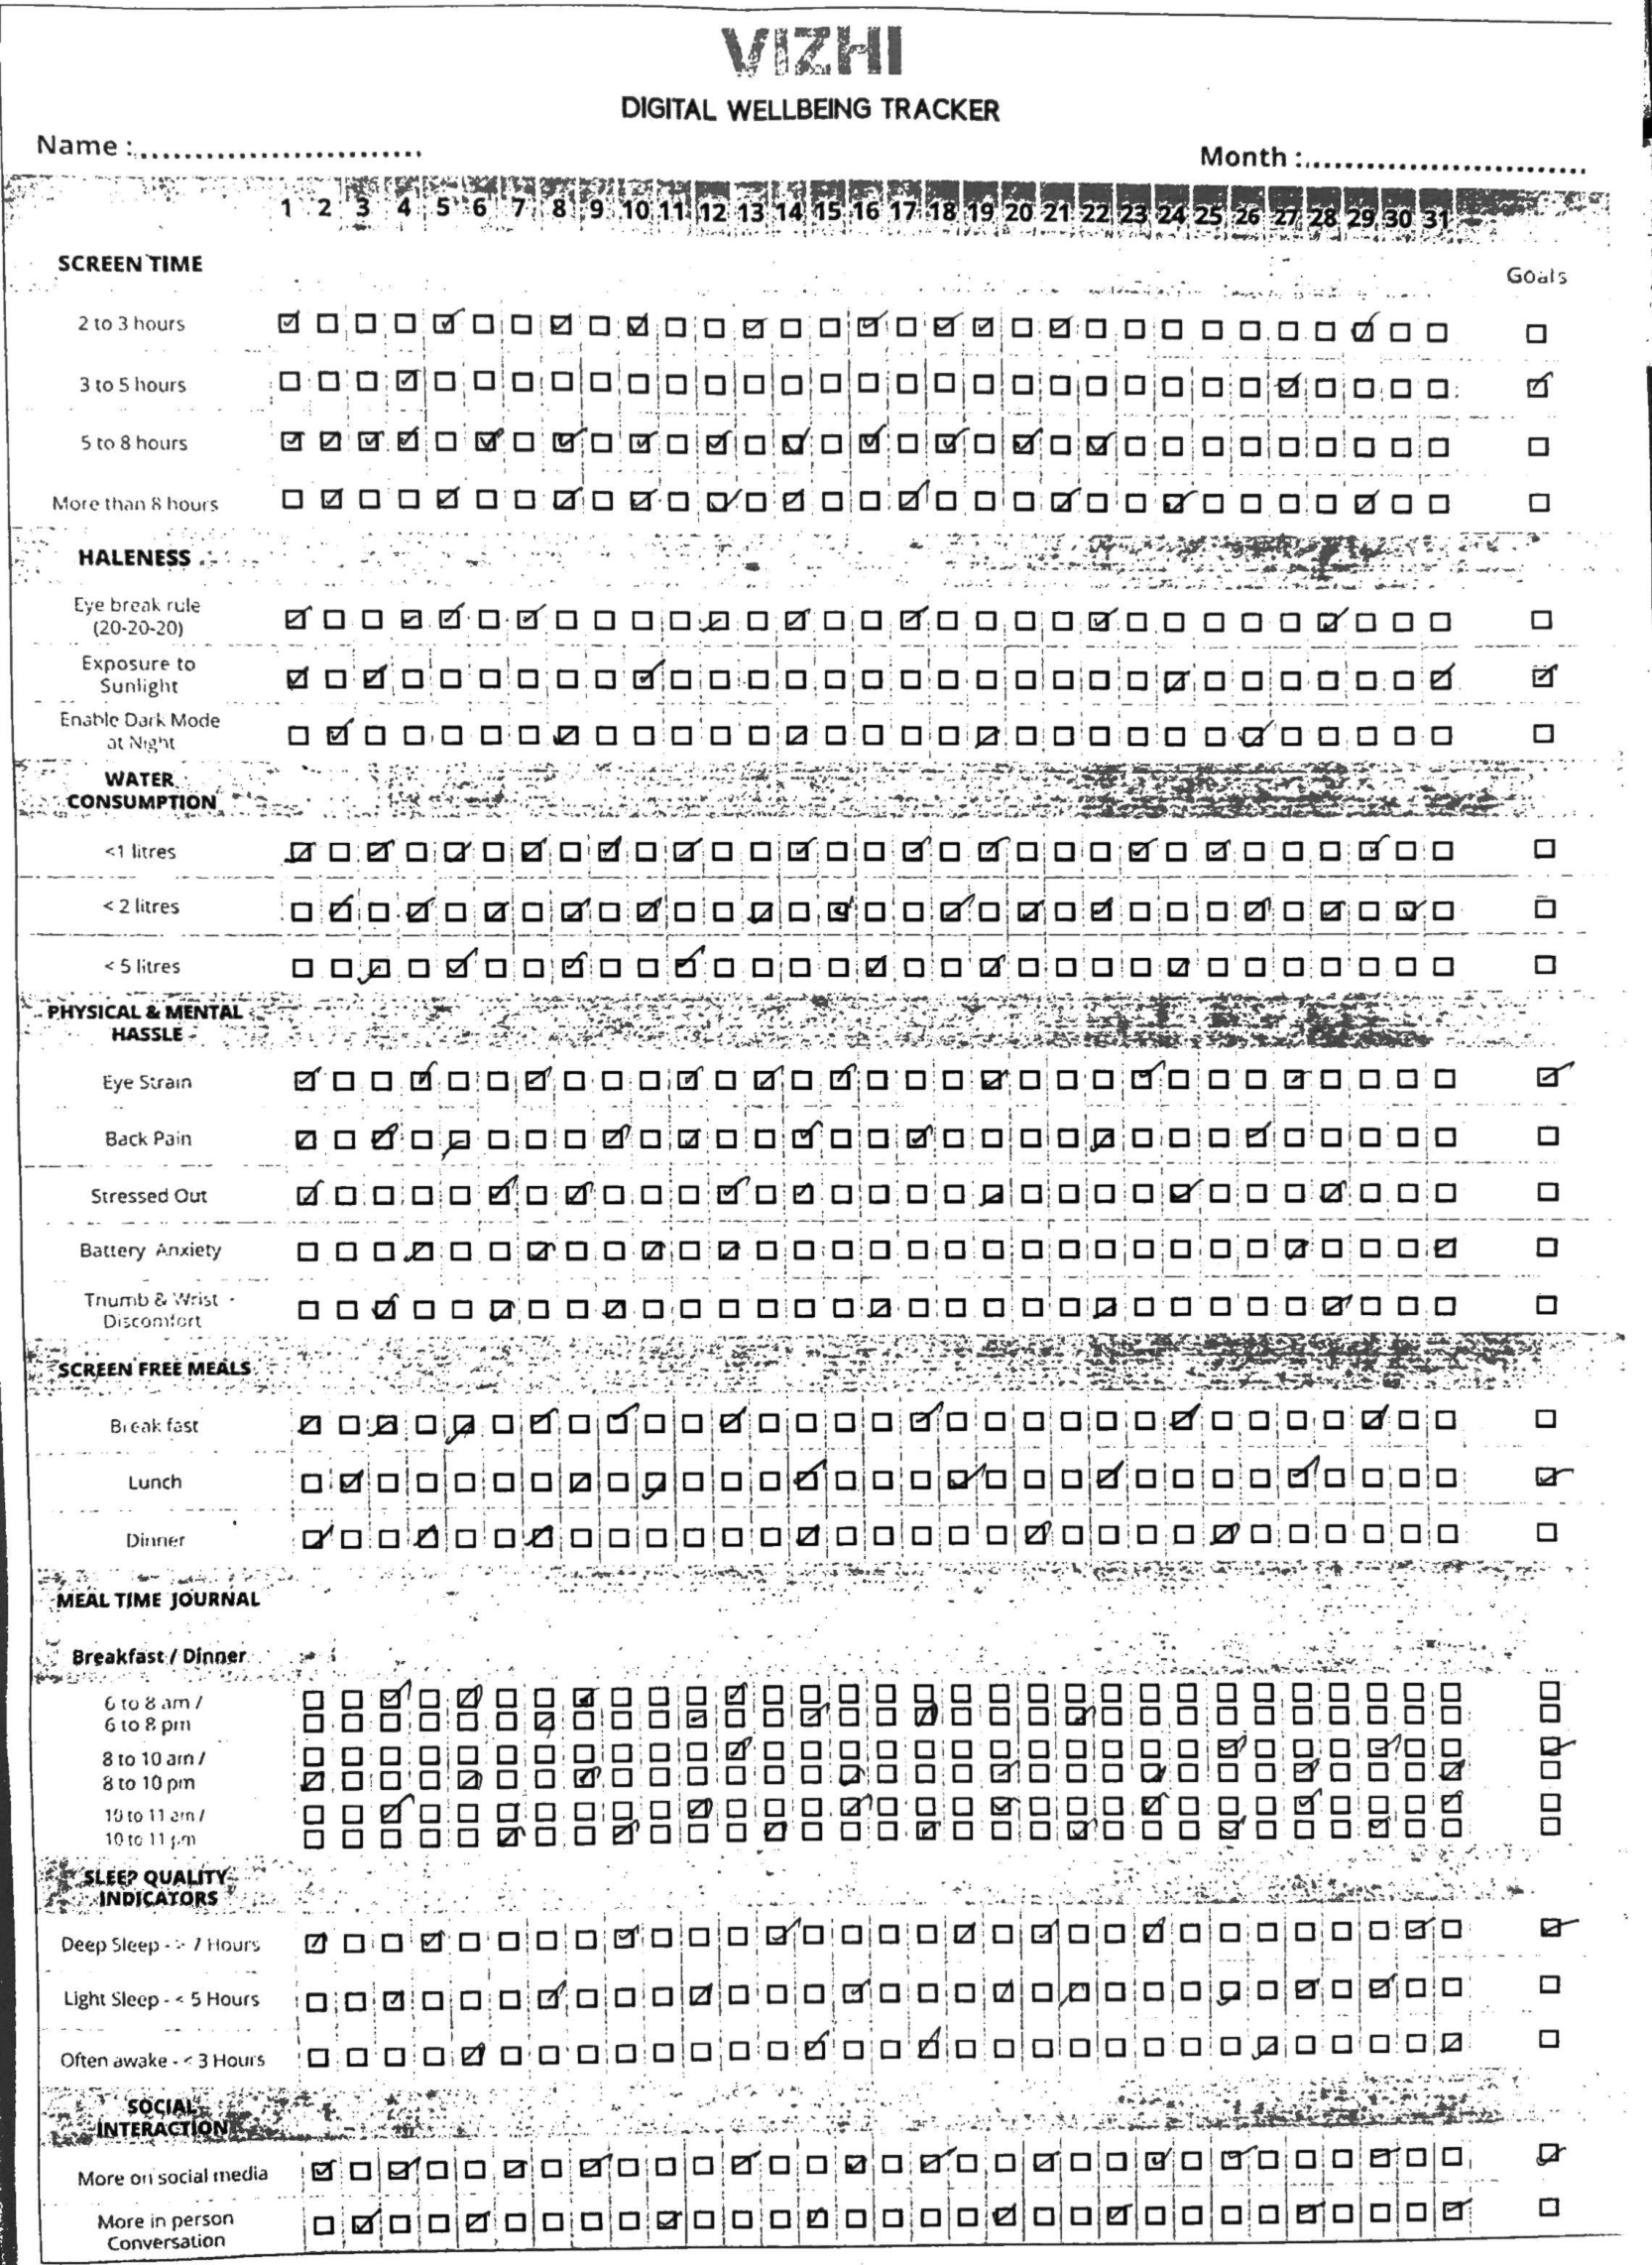

In [2]:
# Display 18x18 pixel image.
Image(filename="image11.png")

In [3]:
import cv2

# Read the original image
image = cv2.imread('image11.png')

# Resize the image to the specified dimensions
resized_image = cv2.resize(image, (2480, 3508))

# Save the resized image to your local storage as a PNG file
cv2.imwrite('image11_resized.png', resized_image)

# Now, `resized_image` holds the resized image array
image_array = resized_image

# Check the type of `image_array`
print(type(image_array))

# If you want to see the dimensions of the resized image
print(image_array.shape)


<class 'numpy.ndarray'>
(3508, 2480, 3)


In [4]:
# Convert image to grayscale
gray_scale_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
img_bin = cv2.adaptiveThreshold(gray_scale_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)

# Invert the image if necessary
img_bin = 255 - img_bin

In [5]:
from PIL import Image
from numpy import *

Image.fromarray(img_bin).show()

In [6]:
# set min width to detect horizontal lines
line_min_width = 15

# kernel to detect horizontal lines
kernal_h = np.ones((1,line_min_width), np.uint8)

# kernel to detect vertical lines
kernal_v = np.ones((line_min_width,1), np.uint8)

# horizontal kernel on the image
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)

# verical kernel on the image
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)

Image.fromarray(img_bin_h).show()
Image.fromarray(img_bin_v).show()
# combining the image

img_bin_final=img_bin_h|img_bin_v

Image.fromarray(img_bin_final).show()


In [7]:
import numpy as np
import cv2

# Assuming 'contours' is already defined and 'image_array' is your image
# First, filter contours by area > 100
#filtered_contour_areas = np.array([cv2.contourArea(cnt) for cnt in contours if  100 < cv2.contourArea(cnt) < 350])
# Detect contours
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas_list = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    
    # Add the area to the list
    if(350<=area<=550):
        areas_list.append(area)

# Convert the list of areas to a NumPy array
areas_array = np.array(areas_list)

# Using mode to find the most common area among the filtered contours
if len(areas_array) > 0:  # Ensure there are contours after filtering
    # Assuming areas_array is already defined and filled with contour areas
    mean_area = np.mean(areas_array)
    
    # Now, use mean_area as needed
    print("Mean area:", mean_area)
    
    # For setting default values for MIN_CHECKBOX_AREA and MAX_CHECKBOX_AREA based on mean_area
    area_tolerance = 150  # You can adjust this tolerance as needed
    MIN_CHECKBOX_AREA = max(0, mean_area - area_tolerance)
    MAX_CHECKBOX_AREA = mean_area + area_tolerance

else:
    print("No contours with area > 100 found.")
    # Handle the case where no valid contours are found
    # This might involve setting default values or skipping certain processing steps

print(MIN_CHECKBOX_AREA, MAX_CHECKBOX_AREA)


_, labels, stats, _ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
checkboxes = []  # List to store information about checkboxes

# Initialize a counter for the checkbox labels
checkbox_counter = 1

for x, y, w, h, area in stats[2:]:
    #print(area)
    if MIN_CHECKBOX_AREA <= area <= MAX_CHECKBOX_AREA:
        # Draw the rectangle on the image
        cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Label the rectangle with a sequential number
        label_position = (x + 5, y + 15)  # Adjust label position as needed
        cv2.putText(image_array, str(checkbox_counter), label_position, cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (255, 0, 0), 1, cv2.LINE_AA)
        checkbox_counter += 1  # Increment the counter
        
        # Save the checkbox details in your list
        checkbox_details = {"x": x, "y": y, "width": w, "height": h, "area": area}
        checkboxes.append(checkbox_details)

# Display the modified image with labels
Image.fromarray(image_array).show()

Mean area: 425.0
275.0 575.0


In [8]:
import csv

with open('checkboxes.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["x", "y", "width", "height", "area"])  # Header
    for checkbox in checkboxes:
        writer.writerow([checkbox["x"], checkbox["y"], checkbox["width"], checkbox["height"], checkbox["area"]])

In [9]:
import pandas as pd

# Load the data from CSV
checkboxes_df = pd.read_csv('checkboxes.csv')

# Sort the DataFrame by the 'y' coordinate to ensure sequential processing
checkboxes_df.sort_values(by='y', inplace=True)

# Initialize variables for processing
groups = []
current_group = []
previous_y = None
group_number = 0  # Initialize group number

# Grouping logic based on y-axis proximity and group size, and sorting each group by the x-axis
for index, row in checkboxes_df.iterrows():
    x, y, width, height, area = row['x'], row['y'], row['width'], row['height'], row['area']
    if previous_y is None or (y - previous_y) <= 10:
        current_group.append(row)
    else:
        # New group due to y-axis gap, check size of the current group
        if len(current_group) >= 25:
            group_number += 1  # Increment group number for each new valid group
            # Sort the current group by the 'x' value
            current_group_sorted = sorted(current_group, key=lambda x: x['x'])
            # Add the group number to each row in the current group
            for item in current_group_sorted:
                item['group_number'] = group_number
            groups.append(current_group_sorted)
        current_group = [row]  # Start a new group
    previous_y = y

# Check and sort the last group after exiting the loop
if len(current_group) >= 25:
    group_number += 1  # Increment group number for the last valid group
    current_group_sorted = sorted(current_group, key=lambda x: x['x'])
    # Add the group number to each row in the current group
    for item in current_group_sorted:
        item['group_number'] = group_number
    groups.append(current_group_sorted)

# Convert groups back to DataFrame and save to a new CSV file, if not empty
if groups:
    all_groups_df = pd.concat([pd.DataFrame(group) for group in groups], ignore_index=True)
    all_groups_df.to_csv('filtered_checkboxes_with_groups.csv', index=False)
    print("Filtered checkboxes with group numbers saved to 'filtered_checkboxes_with_groups.csv'.")
else:
    print("No groups met the criteria.")


Filtered checkboxes with group numbers saved to 'filtered_checkboxes_with_groups.csv'.


In [10]:
from joblib import load
import pandas as pd
import cv2
import numpy as np

# Path to the form image containing all checkboxes
image_path = 'C:\\Users\\shrih\\anaconda3\\jupyter\\InnovationPractices\\image11_resized.png'  # Update this to the path of your form image

def extract_resize_prepare(image, x, y, width, height, target_size=(40, 40)):
    # Extract the checkbox based on the provided coordinates
    checkbox_image = image[y:y+height, x:x+width]
    
    # Resize the checkbox to the target size expected by the model
    resized_image = cv2.resize(checkbox_image, target_size, interpolation=cv2.INTER_AREA)
    
    # Normalize pixel values to be between 0 and 1
    img_array = np.array(resized_image).flatten() / 255.0
    
    return img_array

# Load the form image once
form_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Load the trained Random Forest model
clf = load('checkbox_classifier.joblib')

# Load your CSV file with the detected checkboxes
checkboxes_df = pd.read_csv('filtered_checkboxes_with_groups.csv')

# Placeholder for classification results
classification_results = []

for index, row in checkboxes_df.iterrows():
    img_array = extract_resize_prepare(
        form_image,
        x=row['x'],
        y=row['y'],
        width=row['width'],
        height=row['height']
    )

    # Use the model to predict the classification (marked=1 or unmarked=0)
    prediction = clf.predict([img_array])[0]
    classification_results.append(prediction)

# Update the DataFrame with the classification results
checkboxes_df['classification'] = classification_results

# Save the updated DataFrame back to a CSV file
checkboxes_df.to_csv('classified_checkboxes.csv', index=False)

print("Updated classifications saved to classified_checkboxes.csv")


Updated classifications saved to classified_checkboxes.csv
